In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.preprocessing.text import Tokenizer

Изучение датасета

In [61]:
data = pd.read_csv('train.csv')

In [62]:
data.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [64]:
data.isnull().sum()

sms      0
label    0
dtype: int64

Text(0.5, 1.0, 'Распределение смс')

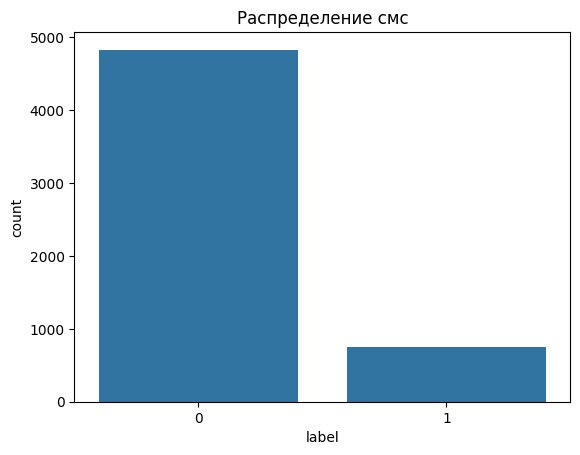

In [65]:
sns.countplot(x = "label", data = data)
plt.title("Распределение смс")

In [66]:
data['label'].value_counts()

label
0    4827
1     747
Name: count, dtype: int64

Предобработка

In [67]:
stopwords = stopwords.words('english') 

In [68]:
def preprocessing(data, stopwords):
    data['sms'] = data['sms'].str.lower() 
    data['sms'] = data['sms'].str.replace('[^A-Za-z0-9]+', ' ', regex=True)
    data['sms'] = data['sms'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))  
    
    return data 

In [69]:
data = preprocessing(data, stopwords)  

Классическая модель

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data['sms'], data['label'], test_size=0.2, random_state=61)

In [71]:
vectorize = CountVectorizer()
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

Для выбора самой подходящей модели для моей задачи я решила сравнить наивный байесовский классификатор и логистическую регрессию.
Критерии сравнения - метрики: доля правильных ответов, точность, полнота, оценка F1.

In [72]:
naivebayes = MultinomialNB()
naivebayes.fit(X_train, y_train)
y_pred_naivebayes = naivebayes.predict(X_test)
print("Наивный байесовский классификатор:")
print("Доля правильных ответов:", accuracy_score(y_test, y_pred_naivebayes))
print("Точность:", precision_score(y_test, y_pred_naivebayes, pos_label=1))
print("Полнота:", recall_score(y_test, y_pred_naivebayes, pos_label=1))
print("Оценка F1:", f1_score(y_test, y_pred_naivebayes, pos_label=1))

Наивный байесовский классификатор:
Доля правильных ответов: 0.9856502242152466
Точность: 0.9530201342281879
Полнота: 0.9403973509933775
Оценка F1: 0.9466666666666667


In [73]:
logisticregression = LogisticRegression()
logisticregression.fit(X_train, y_train)
y_pred_logisticregression = logisticregression.predict(X_test)
print("Логистическая регрессия:")
print("Доля правильных ответов:", accuracy_score(y_test, y_pred_logisticregression))
print("Точность:", precision_score(y_test, y_pred_logisticregression, pos_label=1))
print("Полнота:", recall_score(y_test, y_pred_logisticregression, pos_label=1))
print("Оценка F1:", f1_score(y_test, y_pred_logisticregression, pos_label=1))

Логистическая регрессия:
Доля правильных ответов: 0.9802690582959641
Точность: 0.9849624060150376
Полнота: 0.8675496688741722
Оценка F1: 0.9225352112676055


Судя по показателям, обе модели предельно точные. Однако наивный байесовский классификатор оказался немного более подходящим для этой определенной задачи.

In [74]:
text = "Click this link to claim your prize."

text_vectorize = vectorize.transform([text])

class_predict = naivebayes.predict_proba(text_vectorize)[0]
class_index = np.argmax(class_predict)
if class_index == 0:
    predicted_class = 'не спам'
else:
    predicted_class = 'спам'

print("Этот текст -", predicted_class)

Этот текст - спам


НС

In [89]:
train_sms, valid_sms, train_label, valid_label = train_test_split(data["sms"], data["label"], test_size=0.2)

In [83]:
tok = Tokenizer(num_words=750)
tok.fit_on_texts(train_sms)
X_train = tok.texts_to_matrix(train_sms, mode='tfidf')
X_valid = tok.texts_to_matrix(valid_sms, mode='tfidf')

In [84]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(train_label.values).long()
X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(valid_label.values).long()

In [85]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [86]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size , hidden_size)
        self.l3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = F.relu(self.l1(x))
        out = self.dropout(out)
        out = F.relu(self.l2(out))
        out = self.dropout(out)
        out = self.l3(out)
        return out
    
input_size = 750
hidden_size = 100
output_size = 2
model = Model(input_size, hidden_size, output_size)

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 25
best_valid_loss = float('inf')
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_pred = torch.max(y_pred, 1)[1]
        train_acc = accuracy_score(y_batch.cpu().numpy(), train_pred.cpu().numpy())
        train_accs.append(train_acc)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_valid.to(device))
        valid_loss = criterion(y_pred, y_valid.to(device))
        valid_losses.append(valid_loss.item())
        valid_pred = torch.max(y_pred, 1)[1]
        valid_acc = accuracy_score(y_valid.cpu().numpy(), valid_pred.cpu().numpy())
        valid_accs.append(valid_acc)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            break

In [91]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
y_pred = model(X_valid.to(device))
valid_pred = torch.max(y_pred, 1)[1]
valid_accuracy = accuracy_score(y_valid.cpu().numpy(), valid_pred.cpu().numpy())
valid_precision = precision_score(y_valid.cpu().numpy(), valid_pred.cpu().numpy())
valid_recall = recall_score(y_valid.cpu().numpy(), valid_pred.cpu().numpy())
valid_f1 = f1_score(y_valid.cpu().numpy(), valid_pred.cpu().numpy())
print(f'Доля правильных ответов: {valid_accuracy:.4f},  Точность: {valid_precision:.4f},  Полнота: {valid_recall:.4f}, Оценка F1: {valid_f1:.4f}')

Доля правильных ответов: 0.9857,  Точность: 0.9792,  Полнота: 0.9156, Оценка F1: 0.9463


In [97]:
text = ["PyTorch is the best!"]
tok_test = tok.texts_to_matrix(text, mode='tfidf')
X_test = torch.from_numpy(tok_test).float()
model.eval()
y_pred = model(X_test.to(device))
test_pred = torch.max(y_pred, 1)[1]
for i, pred in enumerate(test_pred.cpu().numpy()):    
    if pred == 0:        
        print(f"не спам")    
    else:        
        print(f"спам")

не спам


Высокие значения метрик и успешная проверка модели на произвольном фрагменте текста показывают, что эта нейронная сеть torch - отличный вариант для задач классификации текста.